In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

In [3]:
import numpy as np
import pylab as plt
import sounddevice as sd
from scipy import signal as sg
import seaborn as sns
from ipywidgets import interactive

plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150

# Преобразование Фурье дискретных сигналов

Многие последовательности представимы в виде:

$X(e^{j\omega}) = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j\omega n}$ - прямое преобразование Фурье

$x[n] = \frac{1}{2\pi}\int\limits_{-\pi}^{\pi}X(e^{j\omega})e^{j\omega n}d\omega$ - обратное преобразование Фурье

## Теоремы о преобразовании Фурье

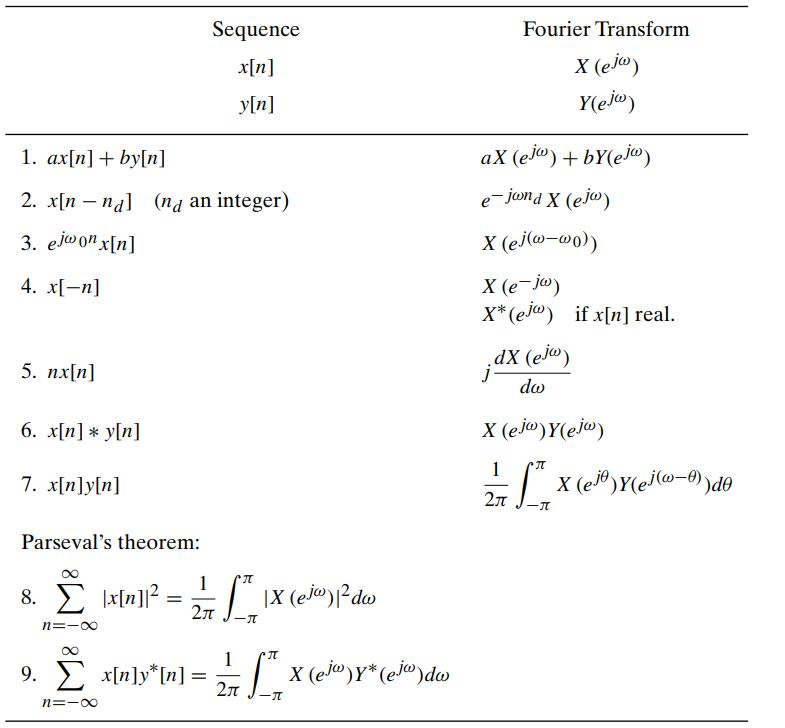

[Теоремы о преобразовании Фурье](https://drive.google.com/file/d/1ZzKvr3-N75Gva450w4Rwsl5pGnLw1QkC/view?usp=share_link)

### Пример

Докажем свойство 4 

$x[n] = a^n u[n]$

$X(e^{j\omega}) = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j\omega n}$

$X(e^{j\omega}) = \sum\limits_{n=-\infty}^{\infty}a^n u[n]e^{-j\omega n}$

$X(e^{j\omega}) = \sum\limits_{n=0}^{\infty}a^n e^{-j\omega n}$

$X(e^{j\omega}) = \sum\limits_{n=0}^{\infty}(a e^{-j\omega})^ n$

$X(e^{j\omega}) = \frac{1}{1 - ae^{-j\omega}}$


In [4]:
def plot_X(a0=4/5, f0=0):
    a = a0 * np.exp(1j*f0)
    n = np.arange(0, 50)
    x = a**n*(n>=0)

    w = np.linspace(-np.pi, np.pi, 1000)
    X = 1/(1-a*np.exp(-1j*w))
    fig, ax = plt.subplots(2, figsize=(8,4))
    ax[0].plot(n, x.real, '.-')
    ax[0].plot(n, x.imag, '.-')
    ax[0].set_title(f'$x[n] = a^n u[n] \cdot e^{"{jfn}"}$, $a={a0}$, $f={f0}$')
    ax[0].set_xlabel('$n$')
    #ax[0].set_ylim(-0.5, 1.5)


    ax[1].set_title(r'$X(e^{j\omega}) = \frac{1}{1 - ae^{-j\omega - jf}}$')
    ax[1].set_xlabel('$\omega$')
    ax[1].plot(w, X.real, '-', label='real')
    ax[1].plot(w, X.imag, '-', label='imag')
    ax[1].plot(w, np.abs(X), '--', label='abs')

    ax[1].legend(loc=2, bbox_to_anchor=(1, 1))
    ax[1].set_xlim(-np.pi, np.pi)
    ax[0].set_ylim(-1, 1)
    ax[1].set_ylim(-10, 20)
    fig.subplots_adjust(hspace=0.7)
    plt.show()

interactive_plot = interactive(plot_X, a0=(0.8, 1, 0.05), f0=(-1, 1, 0.5))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.8, description='a0', max=1.0, min=0.8, step=0.05), FloatSlider(value…

## Пары связанные преобразованием Фурье
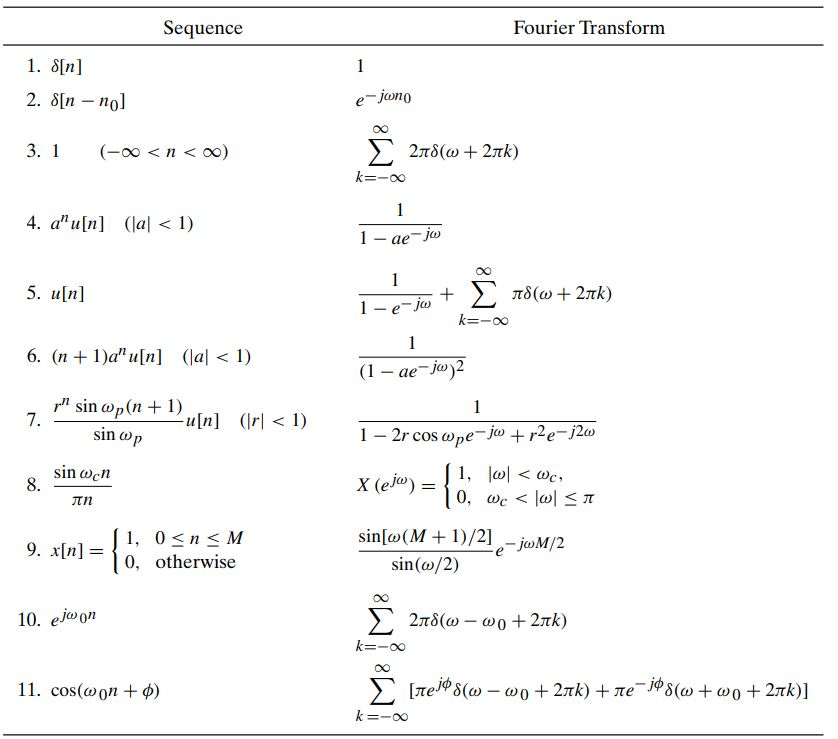


[Пары, связанные преобразованием Фурье](https://drive.google.com/file/d/1bzKu40-8OnQYq958XrQAuFPKPQgI6Pgu/view?usp=sharing)

## Идеальный фильтр низких частот (lowpass filter)

$H(e^{j\omega}) = \begin{cases} 1, |\omega|\le\omega_c,\\ 0, \omega_c<|\omega|<\pi\\ \end{cases}$

(-0.5, 1.5)

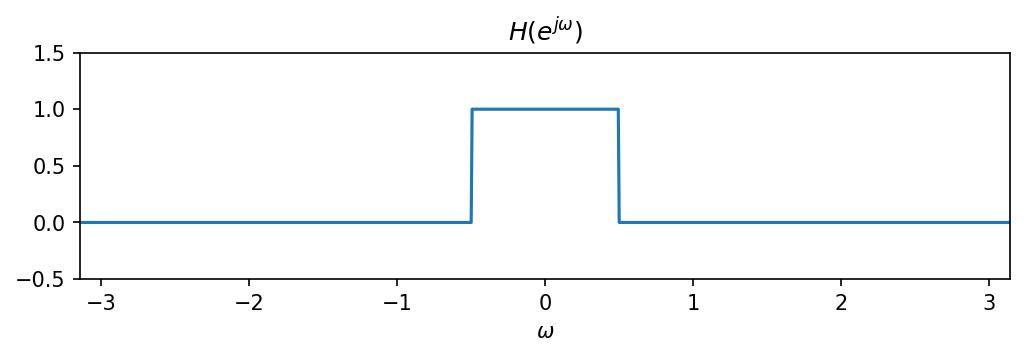

In [5]:
w_c = 0.5
w = np.linspace(-np.pi, np.pi, 1000)
H = np.zeros_like(w)
H[np.abs(w)<=w_c] = 1

plt.title('$H(e^{j\omega})$')
plt.xlabel('$\omega$')
plt.plot(w, H, '-')
plt.xlim(-np.pi, np.pi)
plt.ylim(-0.5, 1.5)
# plt.tight_layout()


КЧХ и импульсная характеристика связаны преобразованием Фурье:

$ H(e^{j\omega}) = \sum\limits_{k=-\infty}^\infty h[k]\cdot e^{-j\omega k}$ 

$h[n] = \frac{1}{2\pi}\int\limits_{-\pi}^{\pi}H(e^{j\omega})e^{j\omega n}d\omega$

$h[n] = \frac{1}{2\pi}\int\limits_{-w_c}^{w_c}e^{j\omega n}d\omega$

При $n\ne0$:

$h[n] = \frac{1}{2\pi jn}e^{j\omega n}\Big|_{-w_c}^{w_c} = \frac{1}{2\pi jn}\Big(e^{j\omega_c n} - e^{-j\omega_c n}\Big) = \frac{sin(\omega_c n)}{\pi n}$

Для $n=0$:

$h[0] = \frac{\omega_c}{\pi n}$

In [6]:
def plot_h(w_c = 0.5):
    n = np.arange(-100, 100)
    h = np.sin(w_c*n)/np.pi
    h[n!=0] /= n[n!=0]
    h[n==0] = w_c/np.pi


    plt.title('$h[n]$')
    plt.xlabel('$n$')
    plt.plot(n, h,'.-', markersize=3, linewidth=0.1)
    plt.show()

interactive_plot = interactive(plot_h, w_c=(0, 1, 0.1))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(FloatSlider(value=0.5, description='w_c', max=1.0), Output()), _dom_classes=('widget-int…

Заменим $h[n]$ на конечную последовательность $h_M[n]$:


$h_M[n] = \begin{cases} h[n], |n|\le M,\\ 0, M < |n|\\ \end{cases}$

Рассмотрим как ведет себя КЧХ для систем с испульсной характеристикой $h_M[n]$:

$ H_M(e^{j\omega}) = \sum\limits_{k=-M}^M \frac{sin(\omega_c n)}{\pi n}\cdot e^{-j\omega k}$ 

In [7]:


def plot_h_H(M = 30, w_c = 0.5):
    n = np.arange(-100, 100)

    h = np.sin(w_c*n)/np.pi
    h[n!=0] /= n[n!=0]
    h[n==0] = w_c/np.pi

    h_M = h.copy()
    h_M[np.abs(n)>M] = 0



    fig, ax = plt.subplots(2, figsize=(8,4))

    ax[0].set_title('$h[n]$')
    ax[0].set_xlabel('$n$')
    ax[0].plot(n, h, '.-', markersize=3, linewidth=0.1)
    ax[0].plot(n, h_M, 'r.-', markersize=3, linewidth=0.1)
    #ax.set_ylim(-0.5, 1.5)
    plt.tight_layout()

    w = np.linspace(-np.pi, np.pi, 1000)
    H = np.zeros_like(w)
    H [np.abs(w)<=w_c] = 1
    H_M = np.sum([h_M[k]*np.exp(-1j*w*n[k]) for k in range(len(n)) if np.abs(n[k])<=M], 0)

    ax[1].set_title('$H(e^{j\omega})$')
    ax[1].set_xlabel('$\omega$')
    ax[1].plot(w, H, '-')
    ax[1].plot(w, np.abs(H_M), 'r-')
    ax[1].set_xlim(-np.pi, np.pi)
    ax[1].set_ylim(-0.5, 1.5)
    plt.tight_layout()
    plt.tight_layout()
    plt.show()


interactive_plot = interactive(plot_h_H, M=(1, 40, 1), w_c=(0, 3, 0.1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=30, description='M', max=40, min=1), FloatSlider(value=0.5, description=…

In [8]:
def plot_hx(M = 30, w_c = 0.5, w_0=1.1):
    n = np.arange(-100, 100)

    h = np.sin(w_c*n)/np.pi
    h[n!=0] /= n[n!=0]
    h[n==0] = w_c/np.pi

    h_M = h.copy()
    h_M[np.abs(n)>M] = 0

    n1 = np.arange(300)
    x = np.sin(w_0*n1)
    
    plt.figure()
    plt.plot(x)
    plt.plot(np.convolve(h_M, x, 'same'))
    plt.show()

    
interactive_plot = interactive(plot_hx, M=(1, 40, 1), w_c=(0, 3, 0.1), w_0=(0, 3, 0.1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=30, description='M', max=40, min=1), FloatSlider(value=0.5, description=…




### Определение импульсной характерисики по разностному уравнению



Пусть $y[n] = S(x[n])$ такая что

$y[n] - 0.5\cdot y[n-1] = x[n] - 0.25\cdot x[n-1]$

Найдем $h[n]$

Пусть $x[n] = \delta[n]$. Так как $h[n] = S(\delta[n])$ то

$h[n] - 0.5\cdot h[n-1] = \delta[n] - 0.25\cdot \delta[n-1]$




Применим преобразование фурье:

$H(e^{j\omega}) - 0.5\cdot e^{-j\omega}\cdot H(e^{j\omega}) = 1 - 0.25\cdot e^{-j\omega}$

$H(e^{j\omega}) = \frac{1-0.25e^{-j\omega}}{1-0.5e^{-j\omega}} $

$H(e^{j\omega}) = \frac{1}{1-0.5e^{-j\omega}} - 0.25\frac{1}{1-0.5e^{-j\omega}}e^{-j\omega}$ 

$h[n] = 0.5^n\cdot u[n] - 0.25\cdot 0.5^{n-1} u[n-1]$